/home/osboxes/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370128159/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
/home/osboxes/anaconda3/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/osboxes/anaconda3/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source

True

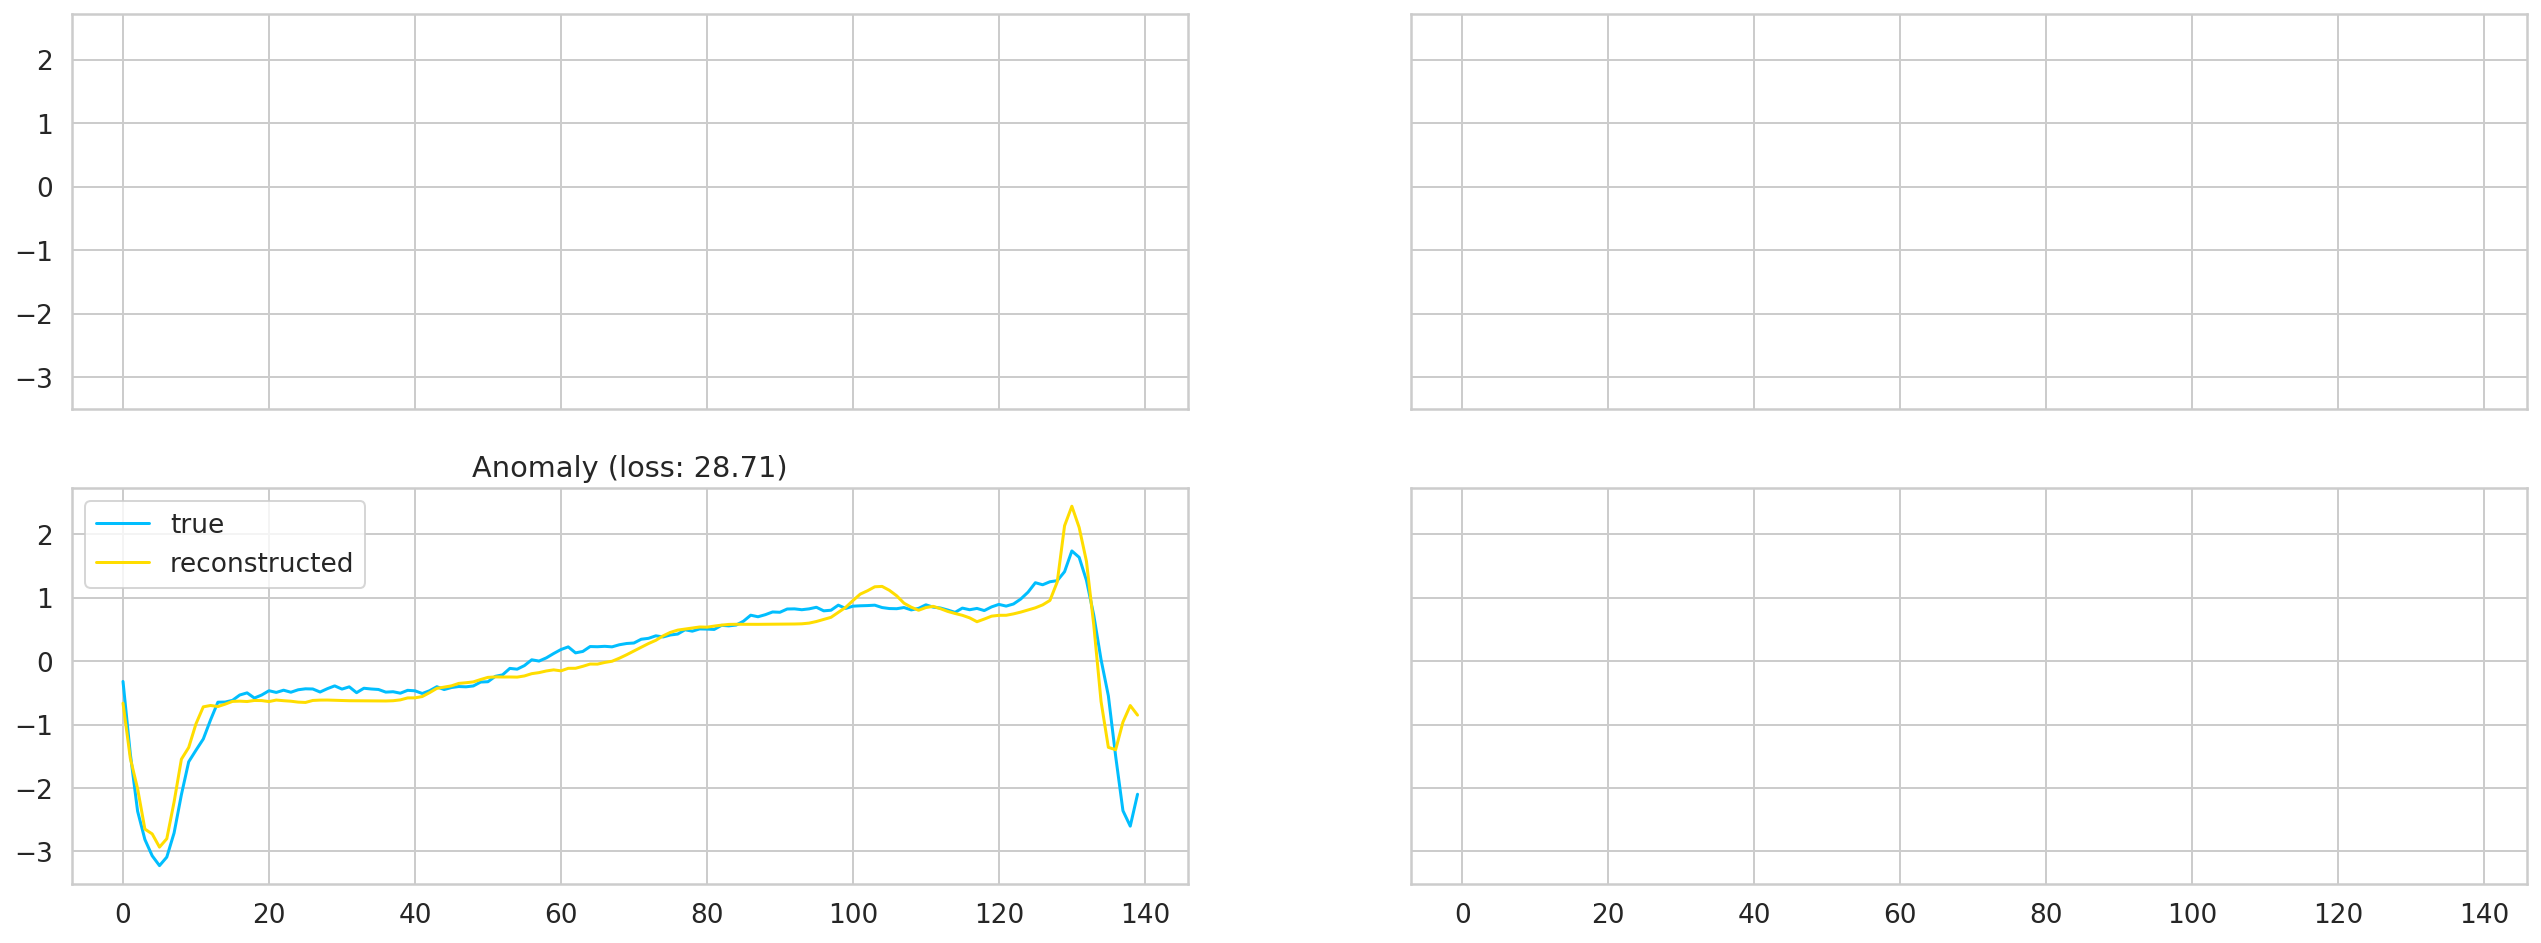

In [1]:
#set up the environment



import paho.mqtt.client as paho
import paho.mqtt.client as mqtt
import sys
import time as t
import json
import AWSIoTPythonSDK.MQTTLib as AWSIoTPyMQTT





import torch
torch.manual_seed(1)

import torch.nn as nn

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import time
import copy
import shutil

from torch import nn, optim

import torch.nn.functional as F
from torchvision import datasets, transforms, models 
from arff2pandas import a2p


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

#set the gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




#load the train and test datasets
with open('ECG5000_TRAIN.arff') as f:
  train = a2p.load(f)

with open('ECG5000_TEST.arff') as f:
  test = a2p.load(f)

# append datasets
df = train.append(test)
df = df.sample(frac=1.0)

# set class names(5 type of heartbeats)
CLASS_NORMAL = 1
class_names = ['Normal','R on T','PVC','SP','UB']

# data preprocessing 
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns


#Let's get all normal heartbeats and drop the target (class) column:
normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis=1)


#We'll merge all other classes and mark them as anomalies:
anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)

# We'll split the normal examples into train, validation and test sets:
#split the normal to tranining and validation
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)
#taking the validation and spliting it further  
val_df, test_df = train_test_split(
  val_df,
  test_size=0.5, 
  random_state=RANDOM_SEED
)






# We need to convert our examples into tensors, so we can use them to train our Autoencoder. Let's write a helper function for that:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

  #Each Time Series will be converted to a 2D Tensor in the shape sequence length x number of features 
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)






#Autoencoder architecture consists of two components
#encoder
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

#decoder
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)


class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

#model trained in GPU and loaded on CPU 
model = torch.load('model.pth', map_location=torch.device('cpu'))
model = model.to(device)




#evaluation (Choosing a threshold)
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

_, losses = predict(model, train_dataset)

#choose threshold
THRESHOLD = 22

#normal predictions
#predictions, pred_losses = predict(model, test_normal_dataset)

#We'll count the correct predictions:
#correct = sum(l <= THRESHOLD for l in pred_losses)

#anomalies
#anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

#Now we can take the predictions of our model for the subset of anomalies:
#predictions, pred_losses = predict(model, anomaly_dataset)

#We'll count the correct predictions:
#correct = sum(l > THRESHOLD for l in pred_losses)





def plot_prediction(data, model, title, ax):
  global eg_loss
  predictions, pred_losses = predict(model, [data])
  eg_loss=np.around(pred_losses[0], 2)
  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()
  


fig, axs = plt.subplots(
  nrows=2,
  ncols=2,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

#selecting a single random value from normal and anomalies test sequences for testing
#single_anomaly = anomaly_df.sample()
#single_normal = test_df.sample()
#single_anomaly_dataset,_,_ = create_dataset(single_anomaly)
#single_normal_dataset,_,_ = create_dataset(single_normal)

#for i, data in enumerate(test_normal_dataset[:1]):
  #plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:1]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])


# connecct to mqtt broker
ENDPOINT = "a386mbo4elm5ey-ats.iot.eu-west-1.amazonaws.com"
CLIENT_ID = "testDevice"
PATH_TO_CERT = "/home/osboxes/Desktop/cert.crt"
PATH_TO_KEY = "/home/osboxes/Desktop/private.key"
PATH_TO_ROOT = "/home/osboxes/Desktop/AmazonRootCA1.pem"
MESSAGE = "Hello World"
TOPIC = "test/testing"
RANGE = 20

myAWSIoTMQTTClient = AWSIoTPyMQTT.AWSIoTMQTTClient(CLIENT_ID)
myAWSIoTMQTTClient.configureEndpoint(ENDPOINT, 8883)
myAWSIoTMQTTClient.configureCredentials(PATH_TO_ROOT, PATH_TO_KEY, PATH_TO_CERT)

myAWSIoTMQTTClient.connect()

# shows if the the patient is normal or needs help 
if eg_loss < 22:
    myAWSIoTMQTTClient.publish("/hassio/notify", "safe", 0)
else:
    myAWSIoTMQTTClient.publish("/hassio/notify", "anomaly", 0)



myAWSIoTMQTTClient.disconnect()


